In [2]:
import datetime
from datetime import date
from dateutil.relativedelta import *
import calendar
from IPython.display import Markdown as md

import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
sns.set(style="darkgrid")

from bokeh.resources import INLINE
from bokeh.io import output_notebook, show
from bokeh.models import ColumnDataSource, HoverTool, CategoricalColorMapper
from bokeh.plotting import figure
from bokeh.palettes import d3, Spectral6, Plasma11, Category20
from bokeh.transform import factor_cmap
import pandas_bokeh
pd.set_option('plotting.backend', 'pandas_bokeh')
output_notebook(INLINE)

Loading BokehJS ...

In [3]:
data = pd.read_csv("ski.csv")
weight = pd.read_csv("morgenvekt.csv")
elsa_weight = pd.read_csv("elsa_vekt.csv")
topptur = pd.read_csv("topptur.csv")

In [4]:
data.head()

,Date,Activity,Distance,Time,Location,Elsa,Elevation
0,2020-02-24,ski-skate,4780,0.0,Bymarka,1,0.0
1,2020-02-29,ski-classic,7690,0.0,Bymarka,1,0.0
2,2020-03-01,ski-classic,12650,0.0,Bymarka,1,0.0
3,2020-03-02,ski-classic,7690,0.0,Bymarka,1,0.0
4,2020-03-03,ski-classic,7690,0.0,Bymarka,1,0.0


In [5]:
weight.head()

,Date,Weight
0,2020-03-03,71.2
1,2020-03-07,71.9
2,2020-03-09,70.7
3,2020-03-10,71.4
4,2020-03-11,72.0


In [6]:
topptur.head()

,Date,Height(m),Distance(m),Time,Location,type,Elsa
0,2020-02-24,110,0,0.0,Grakallen,AT,1
1,2020-02-24,110,0,0.0,Grakallen,AT,1
2,2020-03-14,300,0,0.0,Klarafjell,AT,1
3,2020-03-29,110,0,0.0,Grakallen,AT,1
4,2020-03-29,110,0,14.0,Grakallen,AT,1


In [7]:
elsa_weight['Date'] = pd.to_datetime(elsa_weight['Date'])
elsa_weight["DateString"] = elsa_weight["Date"].dt.strftime("%d-%m-%Y")
data['Date'] = pd.to_datetime(data['Date'])
data["DateString"] = data["Date"].dt.strftime("%d-%m-%Y")
data["distance_cumsum"] = data["Distance"].cumsum() / 1000
weight["Date"] = pd.to_datetime(weight["Date"])
weight["DateString"] = weight["Date"].dt.strftime("%d-%m-%Y")

In [8]:
ski_distance = data.query("Activity == 'ski-classic' or Activity == 'ski-skate'")["Distance"]
run_distance = data.query("Activity == 'run'")["Distance"]
swim_distance = data.query("Activity == 'swim'")["Distance"]

print("####  Langrenn  ####")
print("Antall turer: ", ski_distance.shape[0])
print("Total Distance: ", np.sum(ski_distance), "meter")
print("Gjennomsnittlig distanse: ", np.round(np.average(ski_distance)), "meter")

print("\n#### Løping ####")
print("Antall turer: ", run_distance.shape[0])
print("Total distanse: ", np.sum(run_distance), "meter")
print("Gjennomsnittlig distanse: ", np.round(np.average(run_distance)), "meter")

print("\n#### Svømming ####")
print("Antall turer: ", swim_distance.shape[0])
print("Total distanse: ", np.sum(swim_distance), "meter")
print("Gjennomsnittlig distanse: ", np.round(np.average(swim_distance)), "meter")

height = topptur["Height(m)"]
print("\n####  Topptur  ####")
print("Antall topper: ", height.shape[0])
print("Totalt høydemeter: ", np.sum(height), "meter")
print("Gjennomsnittlig høydemeter: ", np.round(np.average(height)), "meter")

dt = date.today() - data.loc[0].Date.date()
total_distance = np.sum(data["Distance"])
print("\n#### Totalt ####")
print("Dager siden første loggføring:", dt.days)
print("Total distanse:", float(total_distance/1000), "km")
print("Gjennomsnittlig daglig distanse:", int(total_distance / dt.days), "meter")

juli_start = pd.Timestamp('2020-07-09 00:00:00')
aug_slutt = pd.Timestamp('2020-08-09 00:00:00')
nr_days = date.today() - juli_start.date()
jul_aug_run = data.query(f"Activity == 'run' and Date >= '{juli_start}'")["Distance"]
jul_aug_swim = data.query(f"Activity == 'swim' and Date >= '{juli_start}'")["Distance"]
jul_aug_bike = data.query(f"Activity == 'bike-offroad' and Date >= '{juli_start}'")["Distance"]
total_adjusted = np.sum(jul_aug_run) + np.sum(jul_aug_swim)*5 + np.sum(jul_aug_bike)/2

print("\n#### 9 juli til 9 august:")
print("Total løpt:", np.sum(jul_aug_run))
print("Total svømt:", np.sum(jul_aug_swim))
print("Total syklet:", np.sum(jul_aug_bike))
print("Total justert:", np.sum(jul_aug_run) + np.sum(jul_aug_swim)*5 + np.sum(jul_aug_bike)/2)

print("Løpt per dag:", np.sum(jul_aug_run) / nr_days.days)

####  Langrenn  ####
Antall turer:  38
Total Distance:  351958 meter
Gjennomsnittlig distanse:  9262.0 meter

#### Løping ####
Antall turer:  20
Total distanse:  153190 meter
Gjennomsnittlig distanse:  7660.0 meter

#### Svømming ####
Antall turer:  9
Total distanse:  5300 meter
Gjennomsnittlig distanse:  589.0 meter

####  Topptur  ####
Antall topper:  9
Totalt høydemeter:  1320 meter
Gjennomsnittlig høydemeter:  147.0 meter

#### Totalt ####
Dager siden første loggføring: 256
Total distanse: 693.918 km
Gjennomsnittlig daglig distanse: 2710 meter

#### 9 juli til 9 august:
Total løpt: 47730
Total svømt: 4070
Total syklet: 93440
Total justert: 114800.0
Løpt per dag: 397.75


### HEI
{{ total_adjusted }}


In [9]:
data["Activity"].unique()

array(['ski-skate', 'ski-classic', 'run', 'swim', 'hiking',
       'bike-offroad', 'bike', 'run-pull'], dtype=object)

In [10]:
p = figure(plot_width=1000, plot_height=400, x_axis_type="datetime", x_axis_label="Dato", y_axis_label="Meter")
color_map = CategoricalColorMapper(factors=data["Activity"].unique(), palette=Spectral6)
hover = HoverTool(
    tooltips = [
        ("date", "@DateString"),
        ("Distance[m]", "@Distance"),
        ("Activity", "@Activity"),
    ],
)
p.add_tools(hover)
p.circle('Date', 'Distance', size=10, fill_alpha=0.2, color={"field": "Activity", "transform": color_map}, legend='Activity', source=data)
p.legend.location = "top_left"
show(p)

In [11]:
p = figure(plot_width=1000, plot_height=400, x_axis_type="datetime", x_axis_label="Dato", y_axis_label="Kilometer", title="Cumulative distance")
color_map = CategoricalColorMapper(factors=data["Activity"], palette=Spectral6)
hover = HoverTool(
    tooltips = [
        ("date", "@DateString"),
        ("Daily [m]", "@Distance"),
        ("Total [km]", "@distance_cumsum"),
    ],
)
p.add_tools(hover)
p.line('Date', 'distance_cumsum', source=data)
show(p)

In [12]:
source = ColumnDataSource(weight)
p = figure(plot_width = 800, plot_height = 400, x_axis_type = "datetime", title="My weight")
p.line('Date', 'Weight', source = source)
hover = HoverTool(
    tooltips = [
        ("date", "@DateString"),
        ("Weight [kg]", "@Weight"),
    ],
)
p.add_tools(hover)
show(p)

In [13]:
elsa_born = date(2019, 10, 11)
today = date.today()
days = (today - elsa_born).days
weeks = days // 7
print("dager: ", days)
print("uker: ", weeks)
age = relativedelta(today, elsa_born)
print(age.months, "maneder,", age.days, "dager")

dager:  392
uker:  56
0 maneder, 26 dager


In [14]:
def growth_func(x,a,b,c):
    func = a*(1 - np.exp(-b*x))+c
    return func

In [15]:
from scipy.optimize import curve_fit

date0 = elsa_weight["Date"].iloc[0]
dateN = elsa_weight["Date"].iloc[-1]
new_idx = pd.date_range(date0, dateN)
new_idx = pd.Index(new_idx, name="Date")
elsa_indexed = elsa_weight.set_index("Date").reindex(new_idx)

# Interpolate missing weights
D = elsa_indexed.interpolate()
D = D.reset_index()
x = D.index.to_numpy() + days - 108
y = D["Weight"].to_numpy()

x_data = np.linspace(0,len(x)-1,len(x))
popt, pcov = curve_fit(growth_func, x_data, y)

In [16]:
print(D)

          Date     Weight  DateString
0   2020-02-15  15.700000  15-02-2020
1   2020-02-16  15.750000         NaN
2   2020-02-17  15.800000         NaN
3   2020-02-18  15.850000         NaN
4   2020-02-19  15.900000         NaN
..         ...        ...         ...
258 2020-10-30  21.469231         NaN
259 2020-10-31  21.476923         NaN
260 2020-11-01  21.484615         NaN
261 2020-11-02  21.492308         NaN
262 2020-11-03  21.500000  03-11-2020

[263 rows x 3 columns]


In [17]:
y_est = growth_func(x_data, *popt)
est = pd.DataFrame(data={"Weight_est": y_est})
elsa_est = D.join(est)


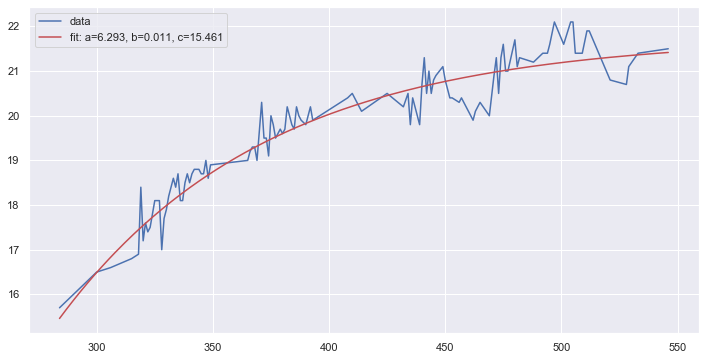

In [18]:
plt.figure(figsize=(12,6))
plt.plot(x, y, 'b-', label='data')
plt.plot(x, y_est, 'r-', label='fit: a=%5.3f, b=%5.3f, c=%5.3f' % tuple(popt))
plt.legend()
plt.show()

In [27]:
growth_func(1000, *popt)

21.753740606060543

In [20]:
g = figure(plot_width=800, plot_height=400, x_axis_type="datetime", title="Elsa's weight")
g.line('Date', 'Weight', source=elsa_est, legend_label="Measured")
g.line('Date', 'Weight_est', source=elsa_est, color="red", legend_label="Estimated")
hover = HoverTool(
    tooltips = [
        ("date", "@DateString"),
        ("Weight [kg]", "@Weight"),
    ],
)
g.legend.location = "top_left"
g.add_tools(hover)
show(g)

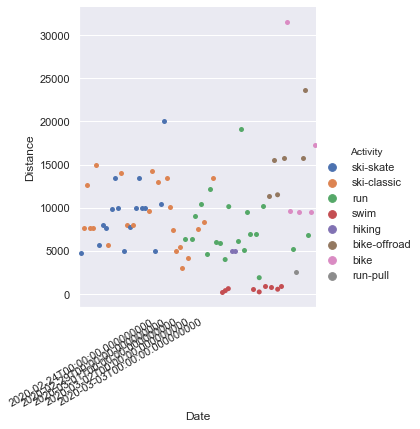

In [21]:
ax = sns.catplot(x="Date", y="Distance", hue="Activity", data=data)
ax.set_xticklabels(rotation=30)
ax.set(xticks=np.arange(0,20,4))

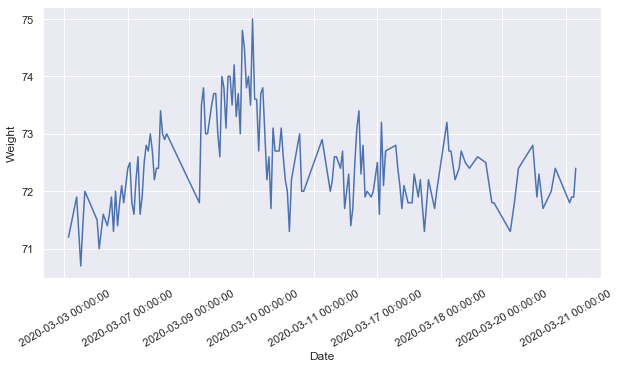

In [22]:
plt.figure(figsize=(10,5))
ax = sns.lineplot(x='Date', y='Weight', data=weight)
ax.set_xticklabels(weight["Date"], rotation=30)
plt.show()

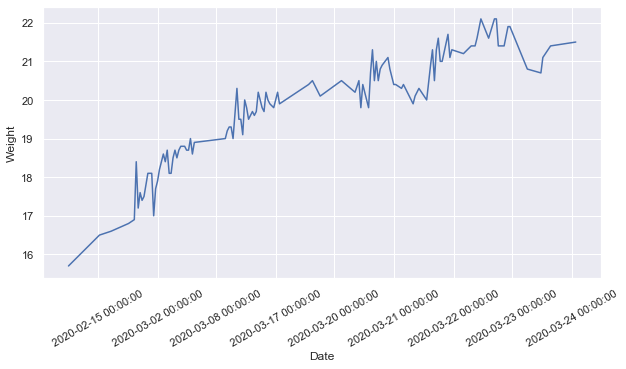

In [23]:
plt.figure(figsize=(10,5))
ax = sns.lineplot(x='Date', y='Weight', data=elsa_weight)
ax.set_xticklabels(elsa_weight["Date"], rotation=30)
print(ax.xaxis.get_major_locator())
print(ax.xaxis.get_major_formatter())
#ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
plt.show()